# Mission 1. 한국 이미지(음식) 데이터셋을 분류하시오.

## 1-1. 각 메뉴를 클래스로 하는 분류 데이터셋과 데이터로더를 준비하고 예시 이미지를 클래스별로 하나씩 총 42장을 한번에 시각화(plotting)하여 확인한다.

### 글꼴 저장 및 드라이브 마운트

In [ ]:
# 글꼴 파일 다운로드
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# 한글 글꼴 설정
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'})

In [ ]:
# 필요한 라이브러리 불러오기
import torch
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
# cuda 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Raw 데이터 시각화

In [ ]:
# 데이터셋의 class 종류 저장 - 이름: class_names
path = "kfood_train/train/"
class_names = os.listdir(path)
print(class_names)
print(len(class_names))

['갈치구이', '김밥', '계란말이', '감자전', '계란후라이', '계란국', '경단', '갈비구이', '곱창구이', '고등어구이', '떡국_만두국', '김치볶음밥', '떡갈비', '무국', '누룽지', '꿀떡', '더덕구이', '닭갈비', '동그랑땡', '김치전', '삼겹살', '생선전', '알밥', '불고기', '새우볶음밥', '시래기국', '북엇국', '미역국', '송편', '비빔밥', '호박전', '육개장', '유부초밥', '파전', '잡곡밥', '장어구이', '조개구이', '콩나물국', '조기구이', '주먹밥', '황태구이', '훈제오리']
42


In [ ]:
# class별 폴더 내 가장 첫번째 이미지의 경로와 class명 dictionary 형태로 저장 - 이름: class_paths
class_paths = {}

for labels in class_names:
    path = "kfood_train/train/"+labels+"/"
    file_list = os.listdir(path)

    if file_list:
        selected_file = os.path.join(path, file_list[0])
        class_paths[labels] = selected_file

for labels, paths in class_paths.items():
    print(f'Label: {labels}, 경로: {paths}')

Label: 갈치구이, 경로: kfood_train/train/갈치구이/Img_001_0231.jpg
Label: 김밥, 경로: kfood_train/train/김밥/Img_069_0190.jpg
Label: 계란말이, 경로: kfood_train/train/계란말이/Img_098_0660.jpg
Label: 감자전, 경로: kfood_train/train/감자전/Img_097_0540.jpg
Label: 계란후라이, 경로: kfood_train/train/계란후라이/Img_099_0553.jpg
Label: 계란국, 경로: kfood_train/train/계란국/Img_014_0473.jpg
Label: 경단, 경로: kfood_train/train/경단/Img_046_0516.jpg
Label: 갈비구이, 경로: kfood_train/train/갈비구이/Img_000_0182.jpg
Label: 곱창구이, 경로: kfood_train/train/곱창구이/Img_003_0329.jpg
Label: 고등어구이, 경로: kfood_train/train/고등어구이/Img_002_0828.jpg
Label: 떡국_만두국, 경로: kfood_train/train/떡국_만두국/Img_015_0374.jpg
Label: 김치볶음밥, 경로: kfood_train/train/김치볶음밥/Img_070_0602.jpg
Label: 떡갈비, 경로: kfood_train/train/떡갈비/Img_006_0033.jpg
Label: 무국, 경로: kfood_train/train/무국/Img_016_0415.jpg
Label: 누룽지, 경로: kfood_train/train/누룽지/Img_071_

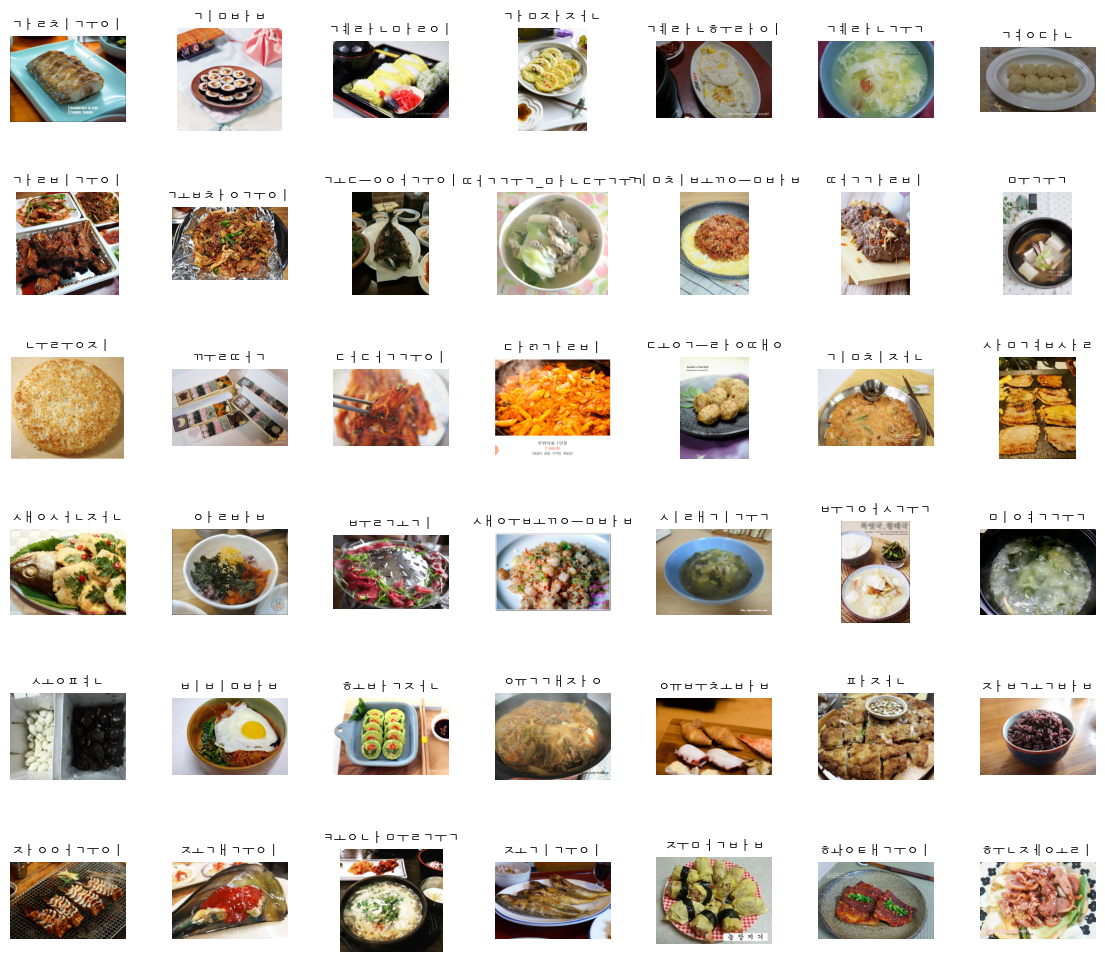

In [ ]:
# class_paths 내 이미지 시각화
from PIL import Image

fig, axes = plt.subplots(6, 7, figsize=(14, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i, (labels, paths) in enumerate(class_paths.items()):
    row, col = divmod(i, 7)
    image = Image.open(paths)
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"{labels}")
    axes[row, col].axis('off')

for i in range(len(class_paths), len(class_names)):
    row, col = divmod(i, 7)
    axes[row, col].axis('off')

### Transformed 데이터 시각화

In [ ]:
# 필요한 라이브러리 불러오기
import os

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 데이터 파일 경로 설정
data_root_train='kfood_train/train'
data_root_val='kfood_val/val'

In [ ]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터 불러오기
data_train = datasets.ImageFolder(root=data_root_train, transform=transform)
data_val= datasets.ImageFolder(root=data_root_val, transform=transform)

In [ ]:
# 데이터 로더 설정
batch_size = 32
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size)

In [ ]:
# 각 클래스별로 하나씩 이미지를 가져오므로 배치 크기를 1로 설정
data_loader = DataLoader(data_train, batch_size=1, shuffle=True)

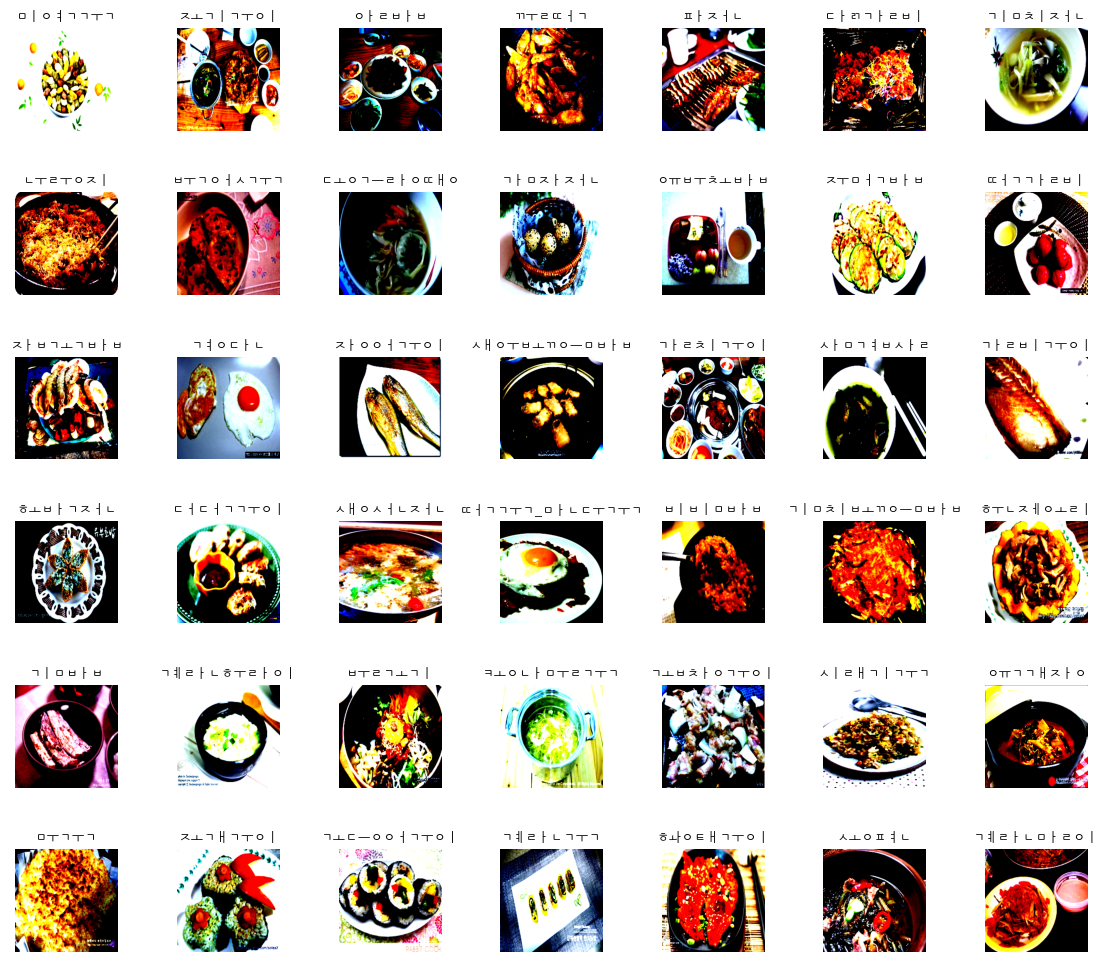

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 7, figsize=(14, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

class_images = {}

for i, (images, labels) in enumerate(data_loader):
    if len(class_images) >= 6 * 7:
        break
    class_name = class_names[labels[0]]
    if class_name not in class_images:
        class_images[class_name] = images[0].permute(1, 2, 0).numpy()
        row, col = divmod(len(class_images) - 1, 7)
        axes[row, col].imshow(np.clip(class_images[class_name], 0, 1))
        axes[row, col].set_title(f"{class_name}")
        axes[row, col].axis('off')

for i in range(len(class_images), 6 * 7):
    row, col = divmod(i, 7)
    axes[row, col].axis('off')

plt.show()

## 1-2. ResNet18를 활용하여 42종의 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시한다.
- ResNet18의 parameters는 무작위로 초기화하여 사용한다.(즉, pretrained weights는 사용할 수 없다.)
- 학습 길이는 50 epoch를 기본으로 하되 추가해도 가능하다.

In [ ]:
# 필요한 라이브러리 불러오기
from tqdm.notebook import tqdm
from torch import nn, optim
from torch.autograd import Variable
from torchvision import models
from torch.backends import cudnn
cudnn.benchmark = True

In [ ]:
# 모델 구축(ResNet18)
ResNet18 = models.resnet18(pretrained=False)

fc_in_features = ResNet18.fc.in_features
ResNet18.fc = nn.Linear(fc_in_features, len(class_names))
ResNet18 = ResNet18.to(device)

In [ ]:
# 모델 summary - batch=32일 때
!pip install torchinfo
from torchinfo import summary

summary(ResNet18, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 42]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [ ]:
# hyperparameters 설정
batch = 32
epochs = 50
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet18.parameters(), lr=lr)

In [ ]:
# 모델 저장 함수
def saveModel(model):
    PATH = "./mission1.pt"
    torch.save(model.state_dict(), PATH)

In [ ]:
# DCC 측에서 제공받은 코드
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
# 모델 학습 함수
def train(model, epochs, batch, criterion, optimizer):

    best_acc = 0.0

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader, 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        print("-----------------")
        print(f"> Epoch {epoch+1}/{epochs}")
        running_loss = running_loss / total_train
        running_acc = 100 * correct_train / total_train
        print(f"Train Loss: {running_loss:.4f},  Train Accuracy: {running_acc:.4f}%")

        acc = validate_epoch(model, val_loader, device)
        print(f'Validation Accuracy: {acc:.4f}%')

        if acc > best_acc:
            saveModel(model)
            best_acc = acc

In [ ]:
# 결과 시각화 함수
def showResult(model, val_loader):
    images, labels = next(iter(val_loader))

    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    print('Real class: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))


    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted class: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(len(images))))

In [ ]:
# 모델 학습
train(ResNet18, epochs, batch, criterion, optimizer)
print('Finished Training')

device: cpu
-----------------
> Epoch 1/50
Train Loss: 106.2894,  Train Accuracy: 10.5736%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 17.3654%
-----------------
> Epoch 2/50
Train Loss: 92.4311,  Train Accuracy: 18.8938%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 24.7022%
-----------------
> Epoch 3/50
Train Loss: 80.7194,  Train Accuracy: 27.8689%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 31.7770%
-----------------
> Epoch 4/50
Train Loss: 72.3928,  Train Accuracy: 34.4715%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 35.9695%
-----------------
> Epoch 5/50
Train Loss: 64.7298,  Train Accuracy: 40.3566%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 41.3292%
-----------------
> Epoch 6/50
Train Loss: 57.2032,  Train Accuracy: 46.6109%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 42.3535%
-----------------
> Epoch 7/50
Train Loss: 49.8495,  Train Accuracy: 53.0795%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 44.6879%
-----------------
> Epoch 8/50
Train Loss: 41.5247,  Train Accuracy: 60.1226%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.0939%
-----------------
> Epoch 9/50
Train Loss: 32.9086,  Train Accuracy: 67.9397%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.9757%
-----------------
> Epoch 10/50
Train Loss: 24.7690,  Train Accuracy: 75.6259%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.8799%
-----------------
> Epoch 11/50
Train Loss: 18.9091,  Train Accuracy: 80.7638%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 49.5950%
-----------------
> Epoch 12/50
Train Loss: 14.4236,  Train Accuracy: 85.3630%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.7608%
-----------------
> Epoch 13/50
Train Loss: 11.7636,  Train Accuracy: 88.2714%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 46.0696%
-----------------
> Epoch 14/50
Train Loss: 10.2667,  Train Accuracy: 89.6943%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.5946%
-----------------
> Epoch 15/50
Train Loss: 8.8418,  Train Accuracy: 90.9803%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.7370%
-----------------
> Epoch 16/50
Train Loss: 8.4851,  Train Accuracy: 91.3821%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.3325%
-----------------
> Epoch 17/50
Train Loss: 7.3412,  Train Accuracy: 92.6651%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.8323%
-----------------
> Epoch 18/50
Train Loss: 7.1547,  Train Accuracy: 92.8705%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.1420%
-----------------
> Epoch 19/50
Train Loss: 6.7988,  Train Accuracy: 93.2813%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.9990%
-----------------
> Epoch 20/50
Train Loss: 6.2616,  Train Accuracy: 93.7040%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.0229%
-----------------
> Epoch 21/50
Train Loss: 5.9496,  Train Accuracy: 94.0315%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 46.8556%
-----------------
> Epoch 22/50
Train Loss: 6.0726,  Train Accuracy: 94.0315%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.4755%
-----------------
> Epoch 23/50
Train Loss: 5.9278,  Train Accuracy: 94.1029%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.8799%
-----------------
> Epoch 24/50
Train Loss: 5.6673,  Train Accuracy: 94.5197%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.5464%
-----------------
> Epoch 25/50
Train Loss: 5.1485,  Train Accuracy: 94.8948%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.4750%
-----------------
> Epoch 26/50
Train Loss: 5.2330,  Train Accuracy: 94.8055%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.5707%
-----------------
> Epoch 27/50
Train Loss: 4.4793,  Train Accuracy: 95.5467%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 46.8556%
-----------------
> Epoch 28/50
Train Loss: 5.4140,  Train Accuracy: 94.7191%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.1653%
-----------------
> Epoch 29/50
Train Loss: 5.0686,  Train Accuracy: 95.1180%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.4035%
-----------------
> Epoch 30/50
Train Loss: 4.3090,  Train Accuracy: 95.8146%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.4040%
-----------------
> Epoch 31/50
Train Loss: 4.6552,  Train Accuracy: 95.5288%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.1177%
-----------------
> Epoch 32/50
Train Loss: 4.6169,  Train Accuracy: 95.5646%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.0943%
-----------------
> Epoch 33/50
Train Loss: 3.9825,  Train Accuracy: 96.1867%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.8085%
-----------------
> Epoch 34/50
Train Loss: 4.7195,  Train Accuracy: 95.4425%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.7132%
-----------------
> Epoch 35/50
Train Loss: 4.2309,  Train Accuracy: 95.8622%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.3082%
-----------------
> Epoch 36/50
Train Loss: 4.3043,  Train Accuracy: 95.8980%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.0224%
-----------------
> Epoch 37/50
Train Loss: 4.3673,  Train Accuracy: 95.7223%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 46.8318%
-----------------
> Epoch 38/50
Train Loss: 3.9004,  Train Accuracy: 96.3594%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.2849%
-----------------
> Epoch 39/50
Train Loss: 4.1585,  Train Accuracy: 95.9754%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.3082%
-----------------
> Epoch 40/50
Train Loss: 3.7149,  Train Accuracy: 96.4189%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 46.8795%
-----------------
> Epoch 41/50
Train Loss: 3.6510,  Train Accuracy: 96.4814%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.2130%
-----------------
> Epoch 42/50
Train Loss: 3.7671,  Train Accuracy: 96.4427%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.2606%
-----------------
> Epoch 43/50
Train Loss: 3.9601,  Train Accuracy: 96.2046%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.4273%
-----------------
> Epoch 44/50
Train Loss: 3.6866,  Train Accuracy: 96.4338%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.2844%
-----------------
> Epoch 45/50
Train Loss: 3.2698,  Train Accuracy: 96.9071%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.4993%
-----------------
> Epoch 46/50
Train Loss: 4.0414,  Train Accuracy: 96.2254%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.5707%
-----------------
> Epoch 47/50
Train Loss: 3.3234,  Train Accuracy: 96.9279%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 45.1644%
-----------------
> Epoch 48/50
Train Loss: 3.5750,  Train Accuracy: 96.6035%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.1891%
-----------------
> Epoch 49/50
Train Loss: 3.5340,  Train Accuracy: 96.5796%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 48.1896%
-----------------
> Epoch 50/50
Train Loss: 3.4905,  Train Accuracy: 96.6600%


measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

Validation Accuracy: 47.3321%
Finished Training


In [ ]:
# 모델 불러오기
state_dict = torch.load("./mission1.pt")

# 모델 정의
load_ResNet18 = models.resnet18(pretrained=False)
load_ResNet18.fc = nn.Linear(load_ResNet18.fc.in_features, 42)# 모델 클래스 정의에 따라 모델 생성

# 불러온 상태 사전을 모델에 로드
load_ResNet18.load_state_dict(state_dict)

load_ResNet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 불러온 모델의 validation accuracy 측정
val_accuracy = validate_epoch(load_ResNet18, val_loader, device)
val_accuracy

measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

49.59504699707031

In [ ]:
# 클래스별 정확도를 저장할 딕셔너리 초기화
class_correct = {classname: 0 for classname in data_train.classes}
class_total = {classname: 0 for classname in data_train.classes}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_ResNet18.to(device)

# 그라디언트가 필요하지 않으므로 no_grad 컨텍스트 내에서 예측 수행
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = load_ResNet18(images)  # 모델을 사용하여 예측 수행
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                class_correct[data_train.classes[label]] += 1
            class_total[data_train.classes[label]] += 1

# 각 클래스별 정확도 출력
sorted_accuracy = sorted(class_correct.items(), key=lambda x: x[1] / class_total[x[0]], reverse=True)

for classname, _ in sorted_accuracy:
    correct_count = class_correct[classname]
    total_count = class_total[classname]
    accuracy = 100 * float(correct_count) / total_count
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: 시래기국  is 79.6 %
Accuracy for class: 송편    is 73.8 %
Accuracy for class: 계란국   is 73.2 %
Accuracy for class: 새우볶음밥 is 69.8 %
Accuracy for class: 파전    is 67.0 %
Accuracy for class: 조개구이  is 65.2 %
Accuracy for class: 잡곡밥   is 64.1 %
Accuracy for class: 김밥    is 64.0 %
Accuracy for class: 육개장   is 63.9 %
Accuracy for class: 황태구이  is 63.8 %
Accuracy for class: 미역국   is 62.2 %
Accuracy for class: 무국    is 61.7 %
Accuracy for class: 꿀떡    is 61.5 %
Accuracy for class: 누룽지   is 59.2 %
Accuracy for class: 알밥    is 59.1 %
Accuracy for class: 닭갈비   is 54.1 %
Accuracy for class: 훈제오리  is 53.1 %
Accuracy for class: 떡국_만두국 is 52.0 %
Accuracy for class: 호박전   is 51.8 %
Accuracy for class: 김치볶음밥 is 51.0 %
Accuracy for class: 계란후라이 is 50.5 %
Accuracy for class: 갈치구이  is 48.5 %
Accuracy for class: 비빔밥   is 47.8 %
Accuracy for class: 김치전   is 47.0 %
Accuracy for class: 북엇국   is 45.3 %
Accuracy for class: 더덕구이  is 43.2 %
Accuracy for class: 떡갈비   is 42.7 %
Accuracy for class: 갈비구이  i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


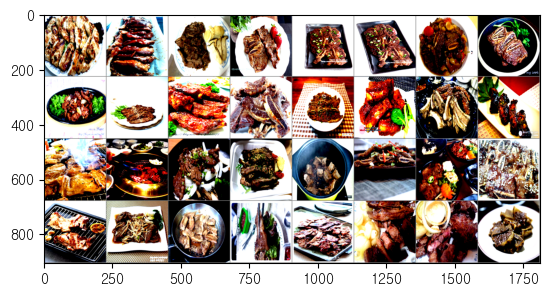

Real class:   갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이  갈비구이
Predicted class:   곱창구이  곱창구이    경단  동그랑땡  동그랑땡  동그랑땡    경단  곱창구이  동그랑땡    경단  곱창구이    경단  곱창구이  곱창구이  곱창구이  곱창구이    경단  곱창구이  곱창구이    경단    경단    경단  곱창구이  곱창구이  곱창구이  동그랑땡    경단    경단  곱창구이    경단    경단    경단


In [ ]:
# 저장된 모델을 통해 결과 시각화하기
showResult(load_ResNet18, val_loader)